This is a small modification to https://www.kaggle.com/dwit392/lgbm-iii converting the question2 file into python code.

## Reading Data and Importing Libraries ##

In [1]:
import riiideducation
# import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
env = riiideducation.make_env()

In [2]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                   usecols=[1, 2, 3, 4, 5, 7, 8, 9],
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   )

In [3]:
#reading in question df
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',                         
                            usecols=[0, 3],
                            dtype={'question_id': 'int16',
                              'part': 'int8'}
                          )

Affirmatives (True) for content_type_id are only for those with a different type of content (lectures). These are not real questions.

In [4]:
#removing True or 1 for content_type_id

train = train[train.content_type_id == False].sort_values('timestamp').reset_index(drop = True)

In [5]:
train[(train.task_container_id == 9999)].tail()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
98994042,65925681553,982752539,1066,0,9999,1,16000.0,True
99088950,68754812937,817562598,12306,0,9999,1,22333.0,True
99088951,68754812937,817562598,12308,0,9999,0,22333.0,True
99088952,68754812937,817562598,12307,0,9999,1,22333.0,True
99207455,73928187913,1071085357,1189,0,9999,1,27000.0,True


In [6]:
train[(train.content_type_id == False)].task_container_id.nunique()

10000

In [7]:
#saving value to fillna
elapsed_mean = train.prior_question_elapsed_time.mean()


In [8]:
group1 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['count'])
group1.columns = ['avg_questions']
group2 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['nunique'])
group2.columns = ['avg_questions']
group3 = group1 / group2

In [9]:
group3['avg_questions_seen'] = group3.avg_questions.cumsum()

In [10]:
group3.iloc[0].avg_questions_seen

1.006648868548182

In [11]:
results_u_final = train.loc[train.content_type_id == False, ['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_final.columns = ['answered_correctly_user']

results_u2_final = train.loc[train.content_type_id == False, ['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_final.columns = ['explanation_mean_user']

In [12]:
results_u2_final.explanation_mean_user.describe()

count    393569.000000
mean          0.566426
std           0.360063
min           0.000000
25%           0.230769
50%           0.655172
75%           0.904110
max           1.000000
Name: explanation_mean_user, dtype: float64

In [13]:
train = pd.merge(train, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

In [14]:
results_q_final = train.loc[train.content_type_id == False, ['question_id','answered_correctly']].groupby(['question_id']).agg(['mean'])
results_q_final.columns = ['quest_pct']

In [15]:
results_q2_final = train.loc[train.content_type_id == False, ['question_id','part']].groupby(['question_id']).agg(['count'])
results_q2_final.columns = ['count']

In [16]:
question2 = pd.merge(questions_df, results_q_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [17]:
question2 = pd.merge(question2, results_q2_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [18]:
question2.quest_pct = round(question2.quest_pct,5)

In [19]:
display(question2.head(), question2.tail())

,question_id,part,quest_pct,count
0,0,1,0.90772,6903
1,1,1,0.89065,7398
2,2,1,0.55428,44905
3,3,1,0.77944,22973
4,4,1,0.61322,31736


,question_id,part,quest_pct,count
13518,13518,5,0.78687,868
13519,13519,5,0.57143,924
13520,13520,5,0.67247,861
13521,13521,5,0.80805,870
13522,13522,5,0.91395,860


In [20]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,0,115,5692,0,1,1,NaN,<NA>,5692,5
1,0,1805962620,5547,0,0,0,NaN,<NA>,5547,5
2,0,2015251289,4024,0,0,1,NaN,<NA>,4024,5
3,0,867941388,6659,0,0,1,NaN,<NA>,6659,5
4,0,867946278,3977,0,0,1,NaN,<NA>,3977,5


In [21]:
len(train)

99271300

## Data Exploration ##

In [22]:
len(train)

99271300

In [23]:
train.answered_correctly.mean()

0.6572355454194717

In [24]:
prior_mean_user = results_u2_final.explanation_mean_user.mean()

In [25]:
train.loc[(train.timestamp == 0)].answered_correctly.mean()

0.6787809364253148

In [26]:
train.loc[(train.timestamp != 0)].answered_correctly.mean()

0.6571491814363561

In [27]:
train.drop(['timestamp', 'content_type_id', 'question_id', 'part'], axis=1, inplace=True)

In [28]:
len(train)

99271300

## Creating Validation Set (Most Recent Answers by User) ##

In [29]:
validation = train.groupby('user_id').tail(5)
train = train[~train.index.isin(validation.index)]
len(train) + len(validation)

99271300

In [30]:
validation.answered_correctly.mean()

0.5405640978205958

In [31]:
train.answered_correctly.mean()

0.6595947874457968

In [32]:
results_u_val = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_val.columns = ['answered_correctly_user']

results_u2_val = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_val.columns = ['explanation_mean_user']

Does it make sense to use last questions as validation? Why is the rate of correct answers so low?
I am convinced there is a better way to match the test data.

## Extracting Training Data ##

In [33]:
X = train.groupby('user_id').tail(18)
train = train[~train.index.isin(X.index)]
len(X) + len(train) + len(validation)

99271300

In [34]:
X.answered_correctly.mean()

0.5518996164435279

In [35]:
train.answered_correctly.mean()

0.6674455337037223

In [36]:
results_u_X = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_X.columns = ['answered_correctly_user']

results_u2_X = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_X.columns = ['explanation_mean_user']

## Merging Data ##

In [37]:
#clearing memory
del(train)

In [38]:
X = pd.merge(X, group3, left_on=['task_container_id'], right_index= True, how="left")
X = pd.merge(X, results_u_X, on=['user_id'], how="left")
X = pd.merge(X, results_u2_X, on=['user_id'], how="left")

In [39]:
validation = pd.merge(validation, group3, left_on=['task_container_id'], right_index= True, how="left")
validation = pd.merge(validation, results_u_val, on=['user_id'], how="left")
validation = pd.merge(validation, results_u2_val, on=['user_id'], how="left")

In [40]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

X.prior_question_had_explanation.fillna(False, inplace = True)
validation.prior_question_had_explanation.fillna(False, inplace = True)

validation["prior_question_had_explanation_enc"] = lb_make.fit_transform(validation["prior_question_had_explanation"])
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])

In [41]:
#reading in question df
#question2 = pd.read_csv('/kaggle/input/question2/question2.csv)

In [42]:
content_mean = question2.quest_pct.mean()

question2.quest_pct.mean()
#there are a lot of high percentage questions, should use median instead?

0.7094600658138017

In [43]:
#filling questions with no info with a new value
question2.quest_pct = question2.quest_pct.mask((question2['count'] < 3), .65)


#filling very hard new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct < .2) & (question2['count'] < 21), .2)

#filling very easy new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct > .95) & (question2['count'] < 21), .95)

In [44]:
X = pd.merge(X, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
validation = pd.merge(validation, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
X.part = X.part - 1
validation.part = validation.part - 1

In [45]:
X.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,avg_questions,avg_questions_seen,answered_correctly_user,explanation_mean_user,prior_question_had_explanation_enc,question_id,part,quest_pct,count
0,867946278,3977,0,1,NaN,False,1.006649,1.006649,NaN,NaN,0,3977,4,0.87455,14428
1,1440786713,3889,0,1,NaN,False,1.006649,1.006649,NaN,NaN,0,3889,4,0.70104,6633
2,1805972720,5796,0,0,NaN,False,1.006649,1.006649,NaN,NaN,0,5796,4,0.74372,3859
3,1805982086,6004,0,1,NaN,False,1.006649,1.006649,NaN,NaN,0,6004,4,0.64486,23022
4,1653617030,4123,0,1,NaN,False,1.006649,1.006649,NaN,NaN,0,4123,4,0.73155,39825


In [46]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)
X.head()

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [47]:
X = X[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]
X_val = X_val[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]

In [48]:

# Filling with 0.5 for simplicity; there could likely be a better value
X['answered_correctly_user'].fillna(0.65,  inplace=True)
X['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X['quest_pct'].fillna(content_mean, inplace=True)

X['part'].fillna(4, inplace = True)
X['avg_questions_seen'].fillna(1, inplace = True)
X['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X['prior_question_had_explanation_enc'].fillna(0, inplace = True)


In [49]:
X_val['answered_correctly_user'].fillna(0.65,  inplace=True)
X_val['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X_val['quest_pct'].fillna(content_mean,  inplace=True)

X_val['part'].fillna(4, inplace = True)
X['avg_questions_seen'].fillna(1, inplace = True)
X_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

## Modeling ##

In [50]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'boosting' : 'gbdt',
    'max_bin': 800,
    'learning_rate': 0.0175,
    'num_leaves': 80
}

lgb_train = lgb.Dataset(X, y, categorical_feature = ['part', 'prior_question_had_explanation_enc'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['part', 'prior_question_had_explanation_enc'], reference=lgb_train)

In [51]:
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=1300,
    early_stopping_rounds=8
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 8 rounds
[50]	training's binary_logloss: 0.613029	valid_1's binary_logloss: 0.625549
[100]	training's binary_logloss: 0.596317	valid_1's binary_logloss: 0.611383
[150]	training's binary_logloss: 0.591898	valid_1's binary_logloss: 0.607579
[200]	training's binary_logloss: 0.590305	valid_1's binary_logloss: 0.606042
[250]	training's binary_logloss: 0.58953	valid_1's binary_logloss: 0.605268
[300]	training's binary_logloss: 0.589029	valid_1's binary_logloss: 0.604692
[350]	training's binary_logloss: 0.588659	valid_1's binary_logloss: 0.604279
[400]	training's binary_logloss: 0.588366	valid_1's binary_logloss: 0.60395
[450]	training's binary_logloss: 0.588166	valid_1's binary_logloss: 0.603755
[500]	training's binary_logloss: 0.588022	valid_1's binary_logloss: 0.603643
[550]	training's binary_logloss: 0.58789	valid_1's binary_logloss: 0.603558
[600]	training's binary_logloss: 0.587773	valid_1's binary_logloss: 0.603503
[650]	training's bin

In [52]:
y_pred = model.predict(X_val)
y_true = np.array(y_val)
roc_auc_score(y_true, y_pred)

0.7340952253354308

## Examining Feature Importance ##

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

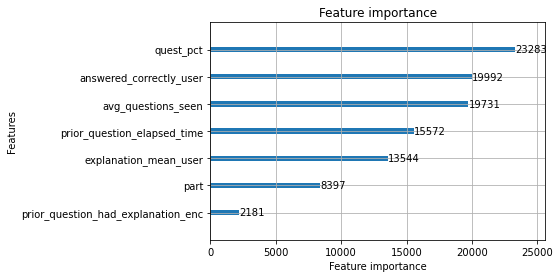

In [54]:
#displaying the most important features by split
lgb.plot_importance(model)
plt.show()

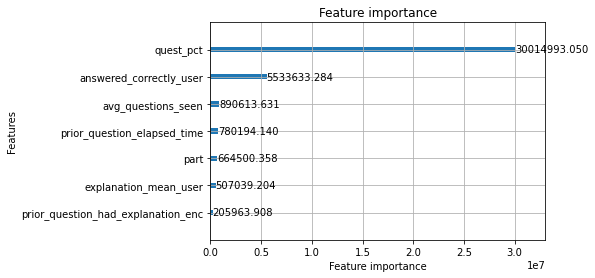

In [55]:
#displaying the most important features by gain
lgb.plot_importance(model, importance_type = 'gain')
plt.show()

## Making Predictions for New Data ##

In [56]:
iter_test = env.iter_test()

In [57]:
for (test_df, sample_prediction_df) in iter_test:
    test_df['task_container_id'] = test_df.task_container_id.mask(test_df.task_container_id > 9999, 9999)
    test_df = pd.merge(test_df, group3, left_on=['task_container_id'], right_index= True, how="left")
    test_df = pd.merge(test_df, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_u2_final, on=['user_id'],  how="left")
    test_df['answered_correctly_user'].fillna(0.65,  inplace=True)
    test_df['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
    test_df['quest_pct'].fillna(content_mean,  inplace=True)
    test_df['part'] = test_df.part - 1

    test_df['part'].fillna(4, inplace = True)
    test_df['avg_questions_seen'].fillna(1, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    
    test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
                                                            'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

In [58]:
#students don't appear in every task container ID what can I do about this, can't always follow sequentially?